# scRNA-Seq pipeline

## Overview 

Using Frozen PBMCs (Donor A), Cell Ranger 1.1.0 dataset available at 10x Genomics, please perform its integration with the whole blood dataset from GEO GSE149938 using scanpy (preferably, but please use R if it is more convenient for you). Please organize all the commands and results in the form of Jupyter notebook. Use the available pre-calculated filtered expression matrices. Briefly discuss the differences and similarities of the two datasets on gene and cell level.

## Early Observations 

The 10x data is hg19 and the data from GEO is hg38. Some genes may be named differently.  


In [1]:
# set enviroment 

import numpy as np
import pandas as pd
import scanpy as sc


# will need to do some extra processing 
# to get GEO data into a AnnData 
import decoupler as dc
from anndata import AnnData


sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')



scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.20.3 scipy==1.7.1 pandas==1.3.4 scikit-learn==0.24.2 statsmodels==0.12.2 pynndescent==0.5.8


In [2]:
results_file_pbmc = '../tables/pbmc.h5ad' # were the resulting analysis will be written. Anndata files are h5ad 
results_file_gse = '../tables/gse149938.h5ad'

## First cluster the PBMC data from 10x 



In [10]:
adata = sc.read_10x_mtx(
    '../data/pbmc10x/filtered_matrices_mex/hg19',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)  

# already filtered so move straight to normalization 
# scaling and inital pca 

sc.pp.normalize_total(adata, target_sum=1e4) 
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca(adata, color='CST3')

# Inital PCA looks ok 

... reading from cache file cache/..-data-pbmc10x-filtered_matrices_mex-hg19-matrix.h5ad


In [13]:
adata.write(results_file_pbmc)
adata

AnnData object with n_obs × n_vars = 2900 × 32738
    var: 'gene_ids', 'mean', 'std'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [17]:
sc.tl.leiden(adata)

running Leiden clustering
    finished: found 9 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


In [18]:
# create neighbourhood graph 
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.paga(adata)
sc.pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(adata, init_pos='paga')
sc.tl.umap(adata)



computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:04)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:05)


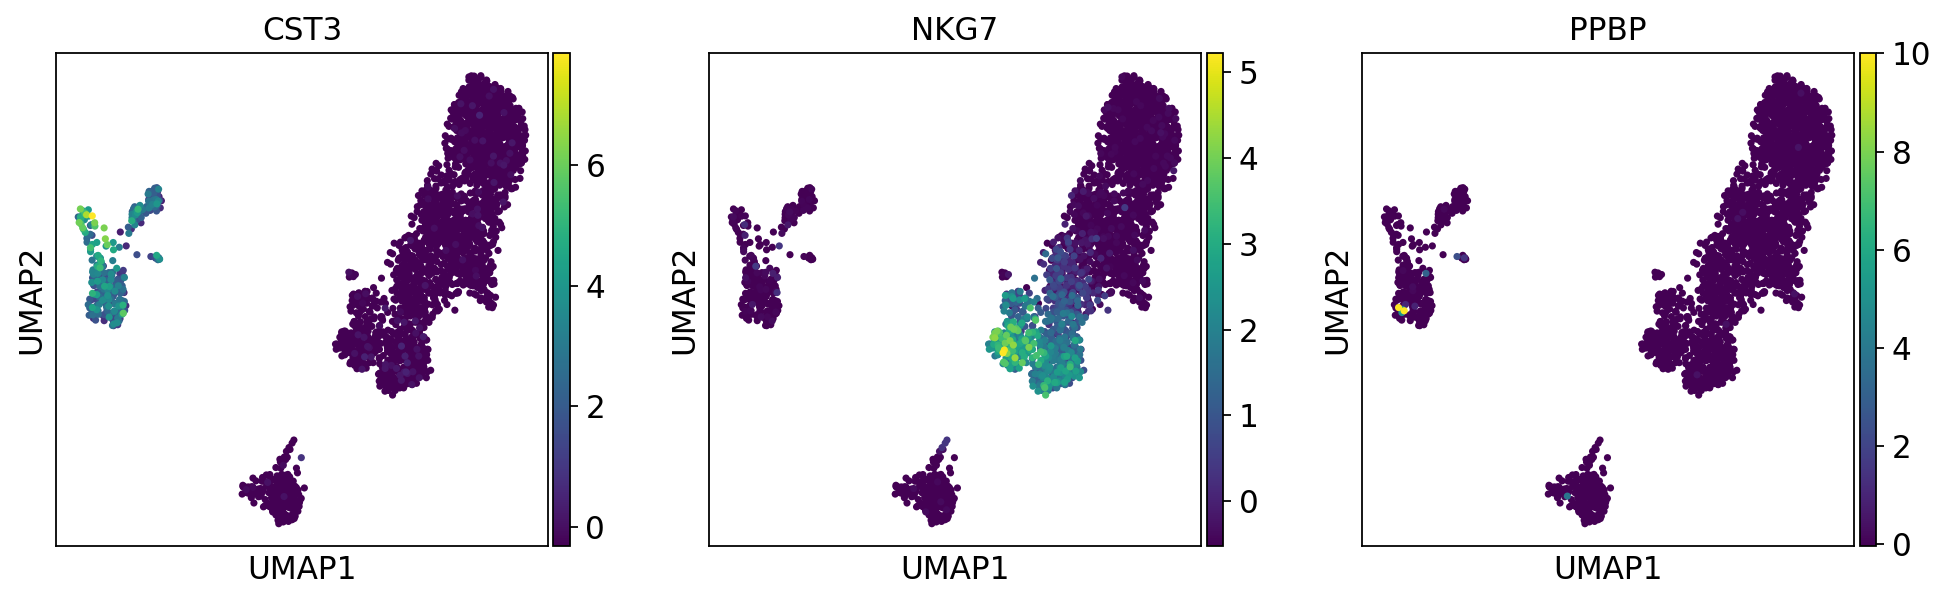

In [19]:
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP']) # looks very close to tutorial 

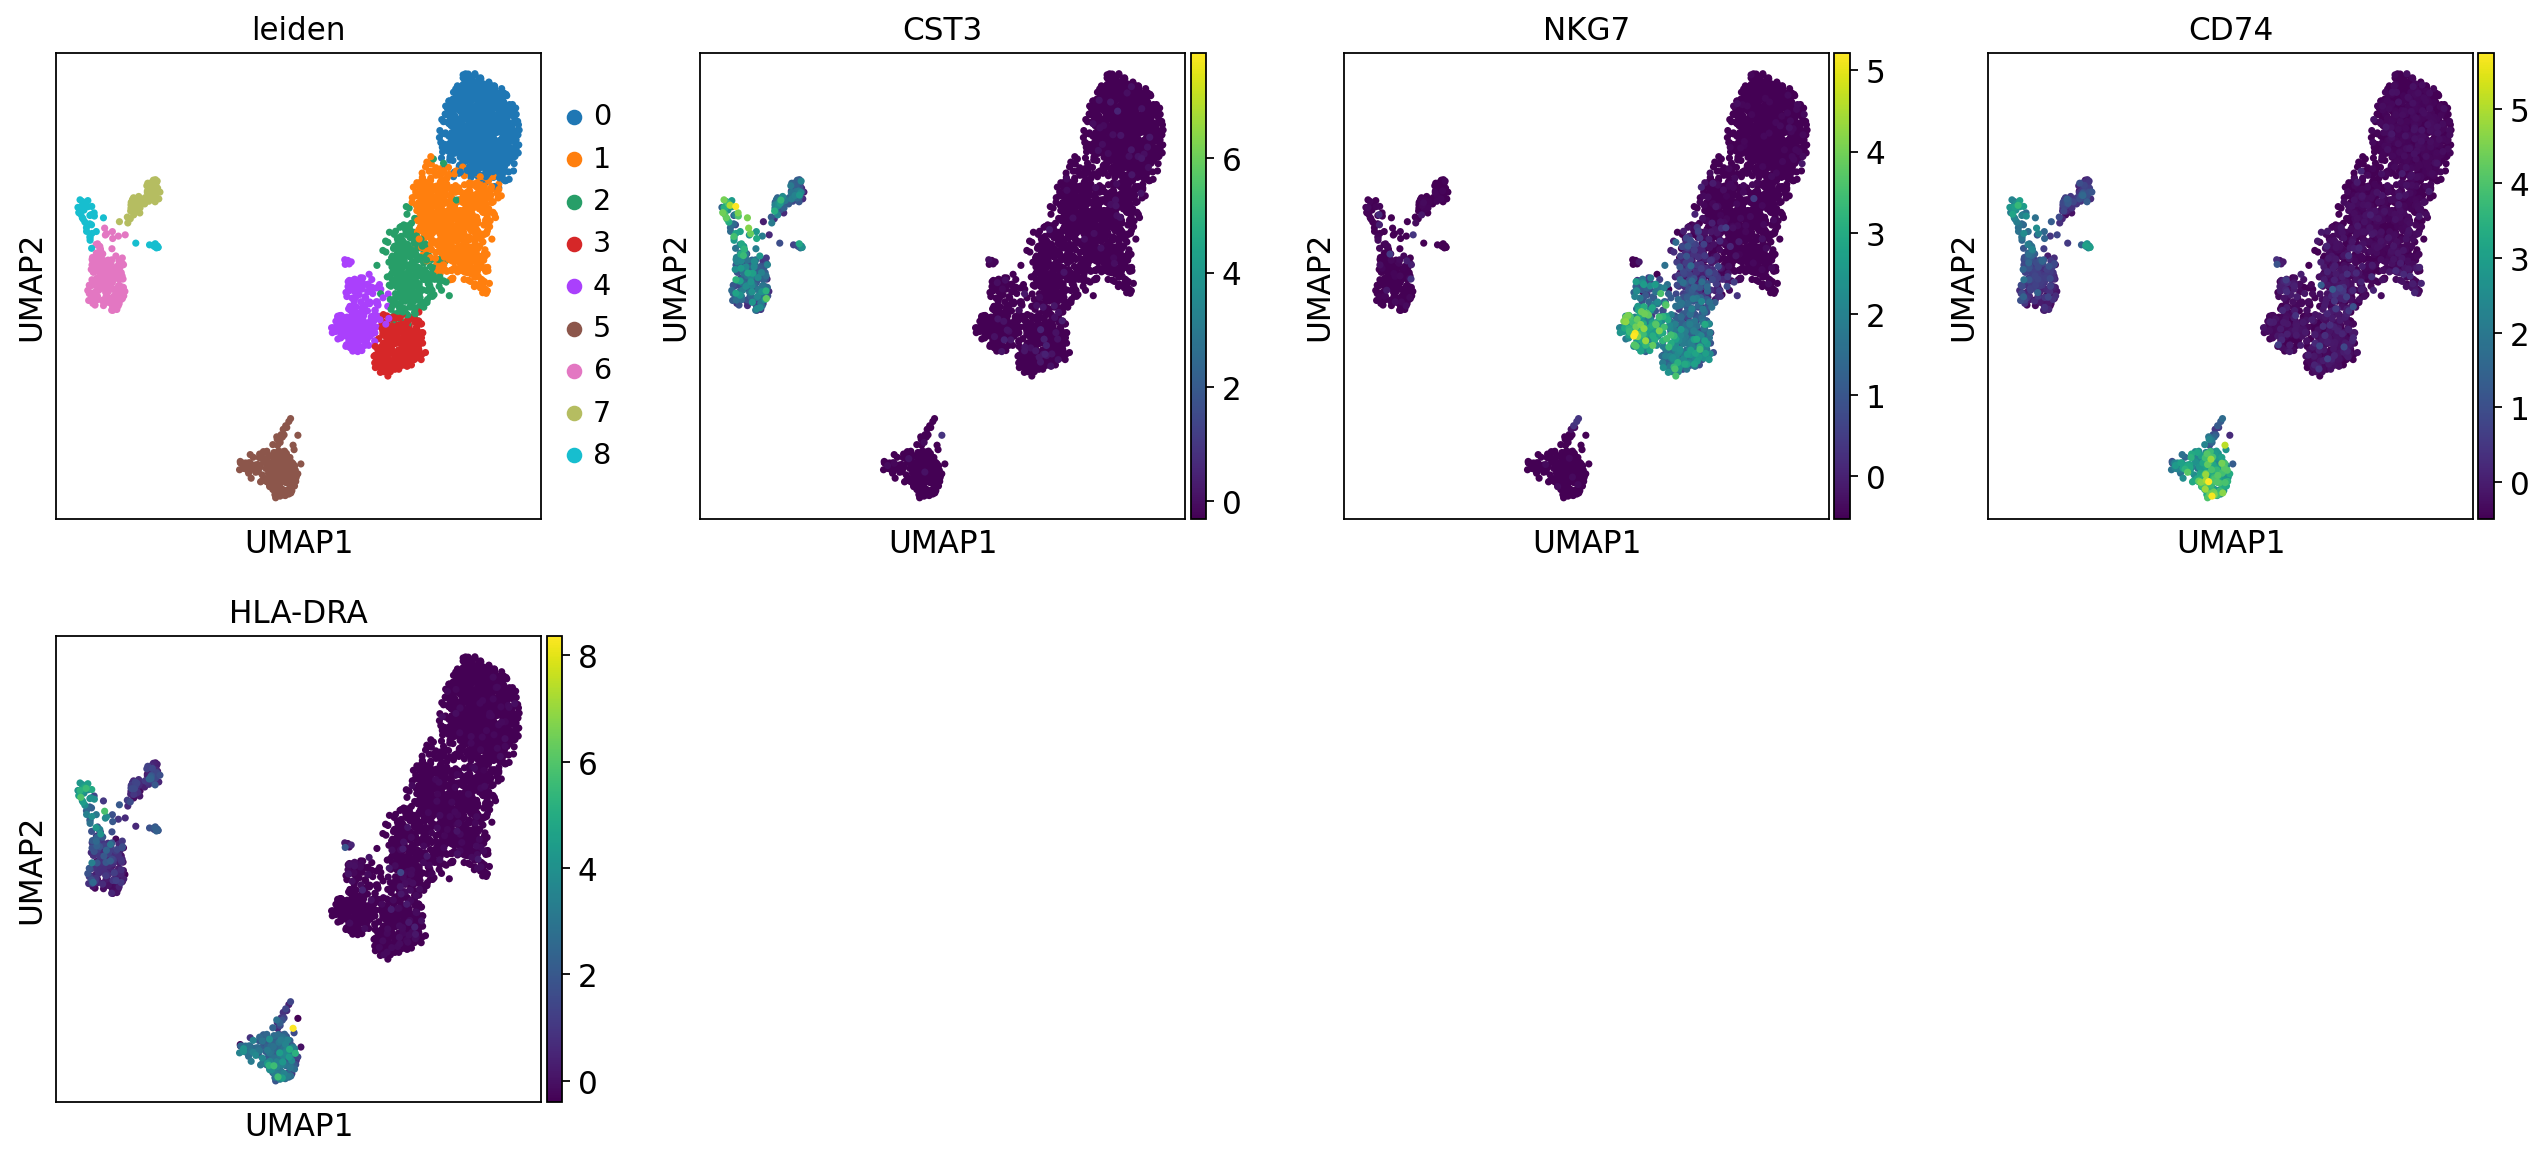

In [33]:
sc.pl.umap(adata, color=['leiden', 'CST3', 'NKG7', 'CD74', 'HLA-DRA']) 
# the tutorial has 7 clusters and I have 8
# this is so problematic as they are from different datasets though both PBMC
# will look into 
adata.write(results_file_pbmc)


ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:03)


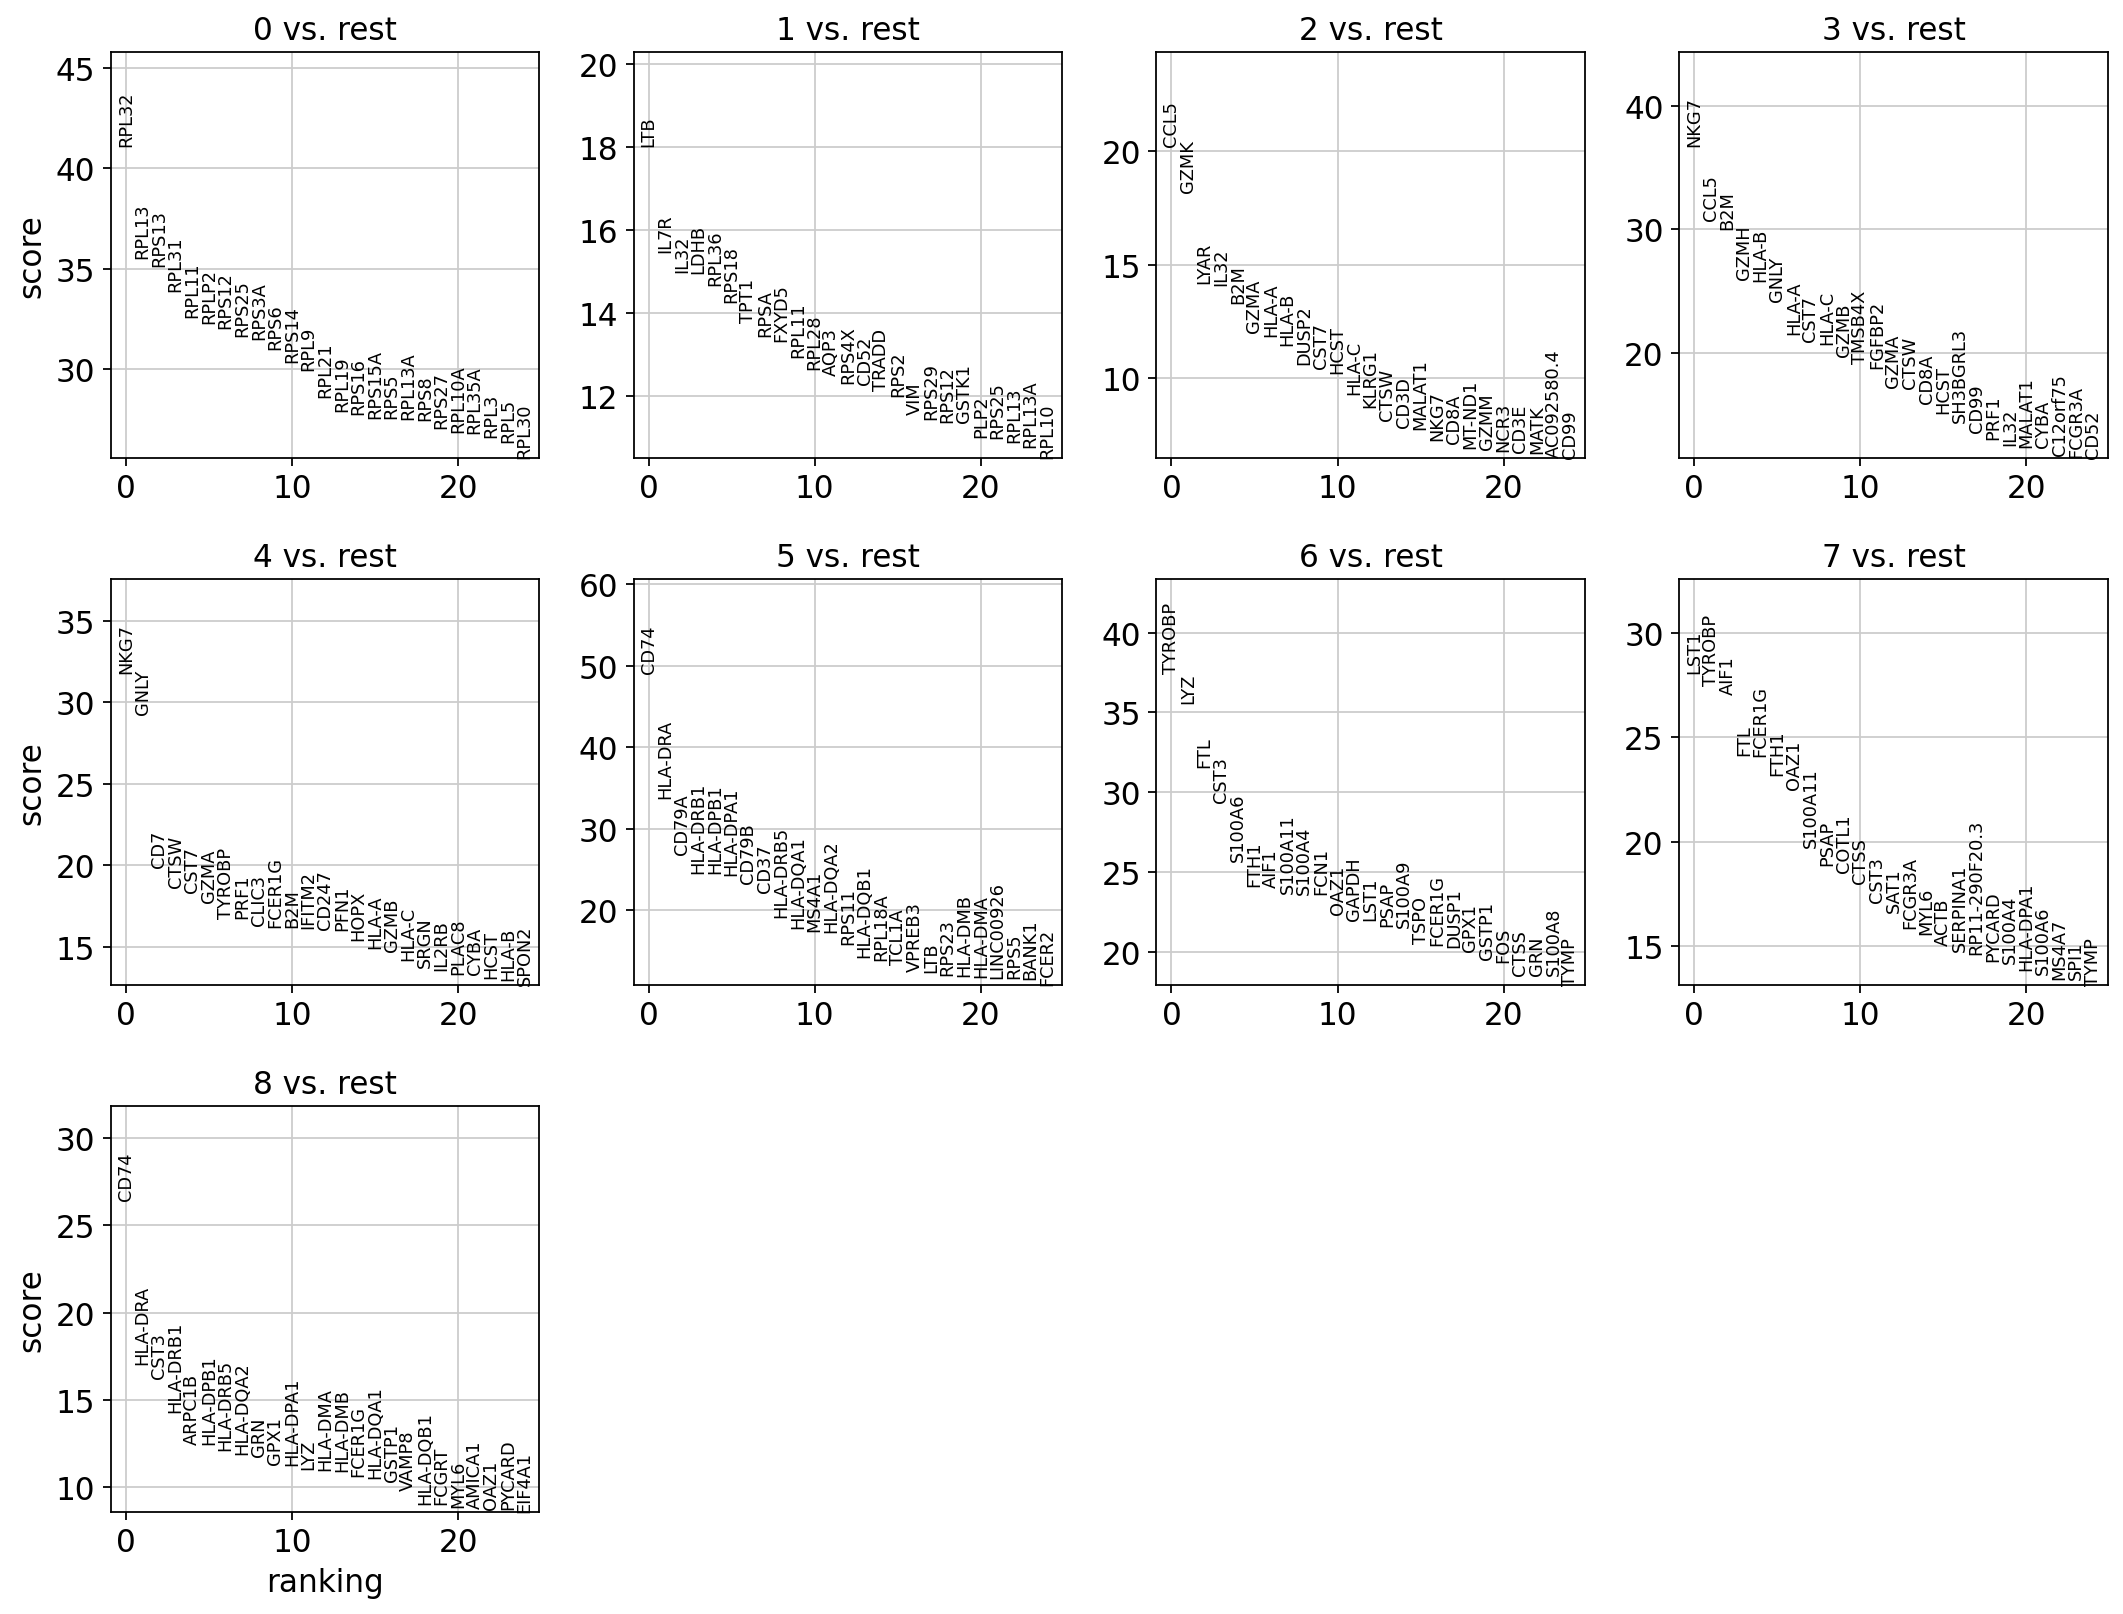

In [31]:
# what are the genes that make 8 different then 7
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

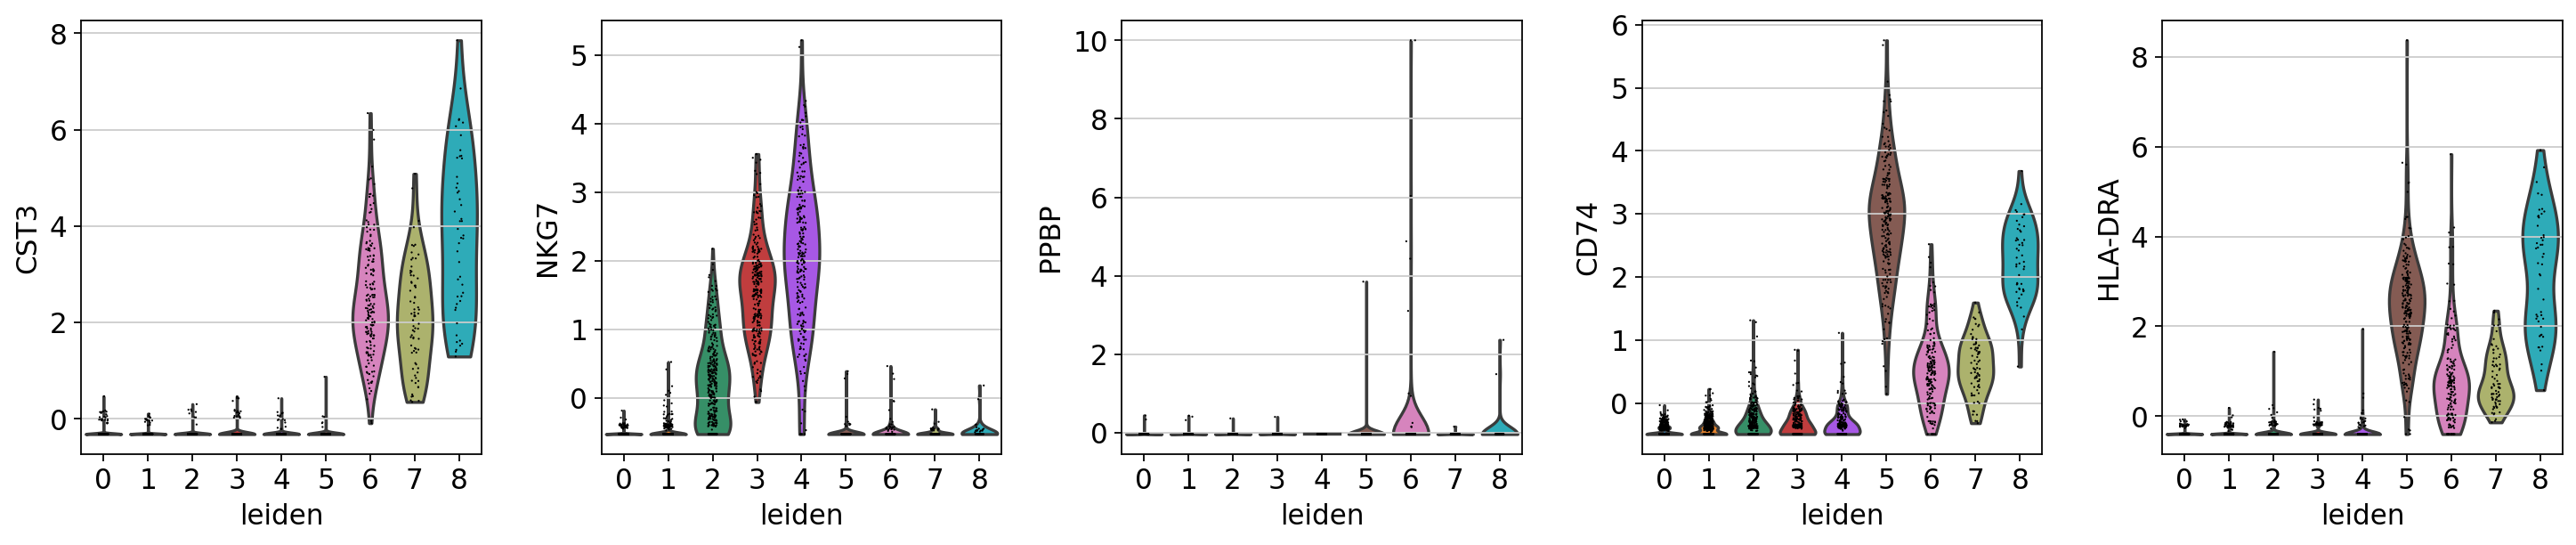

In [36]:
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

sc.pl.violin(adata, ['CST3', 'NKG7', 'PPBP', 'CD74', 'HLA-DRA'], groupby='leiden')